In [1]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle
import numpy as np

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# os.system(f"ls {oneactor_dir}")

In [3]:
from PIL import Image
import numpy as np

# Ensure tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)

def display_images(source_dir, source_file, sdxl_fdir, sdxl_file, oneactor_dir, oneactor_files):
    f, axarr = plt.subplots(1, 2 + len(oneactor_files), figsize=(20, 10))
    axarr[0].imshow(Image.open(source_dir + source_file))
    axarr[1].imshow(Image.open(sdxl_fdir + sdxl_file))
    for n, image_file in enumerate(oneactor_files):
        axarr[n+2].imshow(Image.open(oneactor_dir + image_file))

def score_recults(source_dir, source_file, sdxl_fdir, sdxl_file, oneactor_dir, oneactor_files):
    display_images(source_dir, source_file, sdxl_fdir, sdxl_file, oneactor_dir, oneactor_files)

    res = {}
    # Load and convert images to RGB and numpy arrays
    source_image = np.array(Image.open(source_dir + source_file).convert("RGB"), dtype=np.uint8)
    source_image = torch.tensor(source_image).permute(2, 0, 1).unsqueeze(0).float()
    source_image = source_image.to(device)
    
    sdxl_image = np.array(Image.open(sdxl_fdir + sdxl_file).convert("RGB"), dtype=np.uint8)
    sdxl_image = torch.tensor(sdxl_image).permute(2, 0, 1).unsqueeze(0).float()
    sdxl_image = sdxl_image.to(device)
    score = metric(sdxl_image, source_image).detach().round()
    res[sdxl_file] = float(score)
    
    
    for image_file in oneactor_files:
        image = np.array(Image.open(oneactor_dir + image_file).convert("RGB"), dtype=np.uint8)
        image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
        image = image.to(device)
    
        # Compute metric and round the score
        # 100 is identical
        score = metric(image, source_image).detach().round()
        res[image_file] = float(score)

    return res

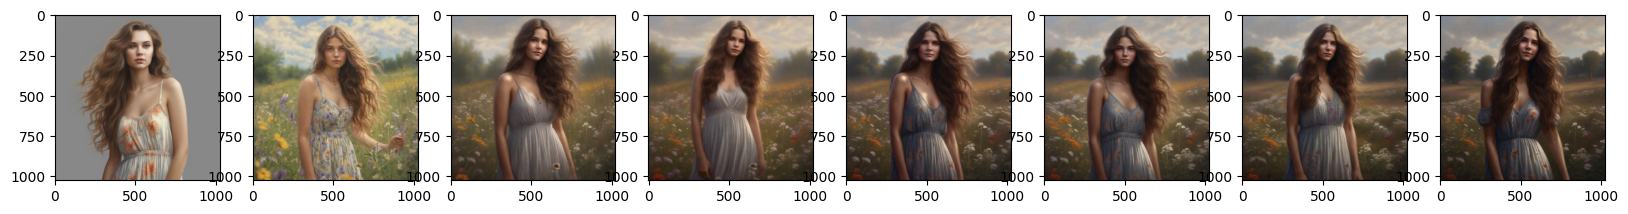

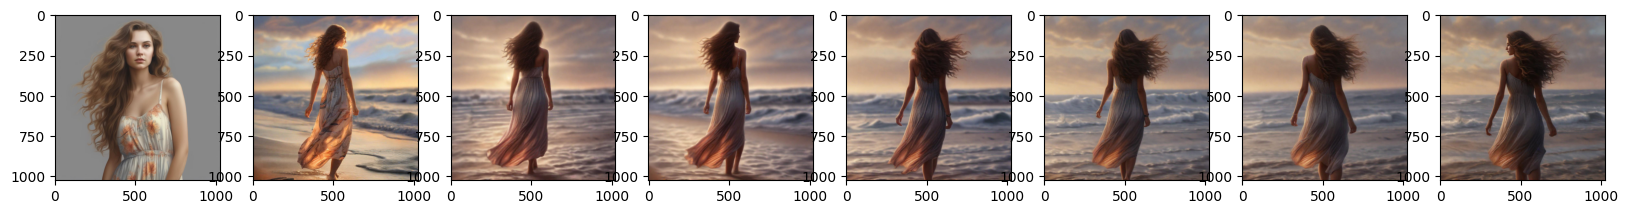

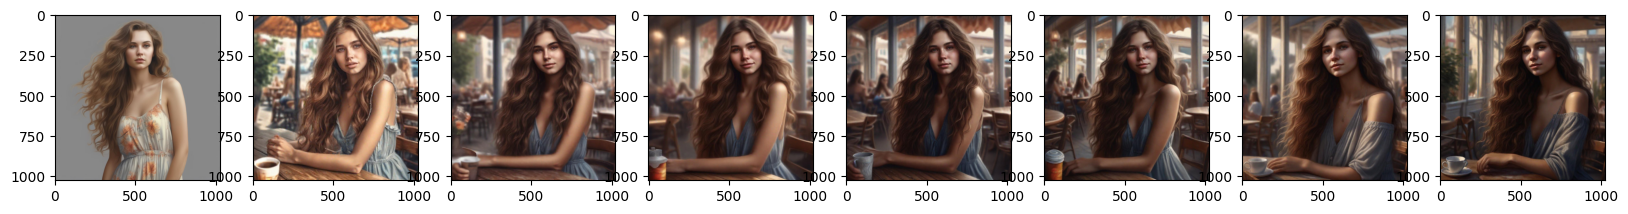

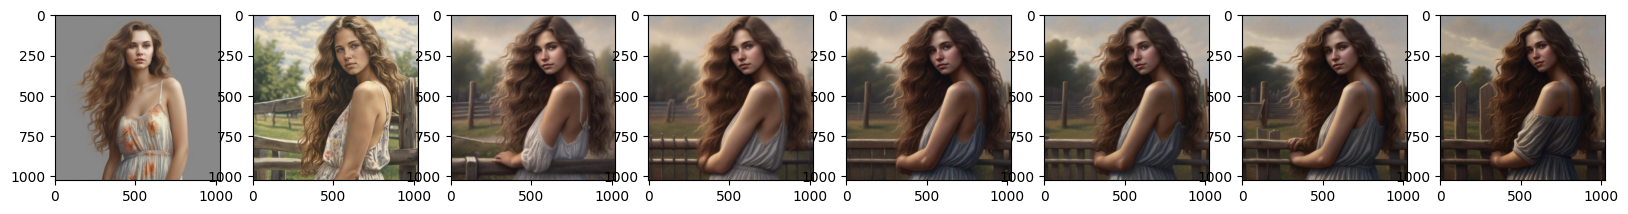

In [4]:
dir_name = 'a_young_woman_with_long_wavy_hair_wairing_sundress_photo_realistic'

oneactor_dir = f'/workspace/OneActor/output/demo/{dir_name}/inference_mask/'
source_dir = f'/workspace/OneActor/data/demo/{dir_name}/'

uuid = 'efcb69dd'
source_file = f'source_{uuid}.jpg'

res = {}
subject_list = ['standing_in_wildflowers',
   'walking_on_sunset_beach',
   'sitting_at_cafe',
   'leaning_on_a_fence']

res = {}
for subject in subject_list:
    oneactor_files = [
        f'OneActor_{subject}_step_{n}_{uuid}.jpg' for n in [20, 40, 80, 120, 160, 200]
    ]
    sdxl_file = f"original_{subject}_sdxl_{uuid}.jpg"
    res[subject] = score_recults(source_dir, source_file, oneactor_dir, sdxl_file, oneactor_dir, oneactor_files)

In [5]:
file_path = "/workspace/OneActor/" + dir_name + f"_ds_{uuid}_mask.pickle"
with open(file_path, "rb") as f:
    res_ds = pickle.load(f)

Text(0.5, 1.0, 'CLIP_score')

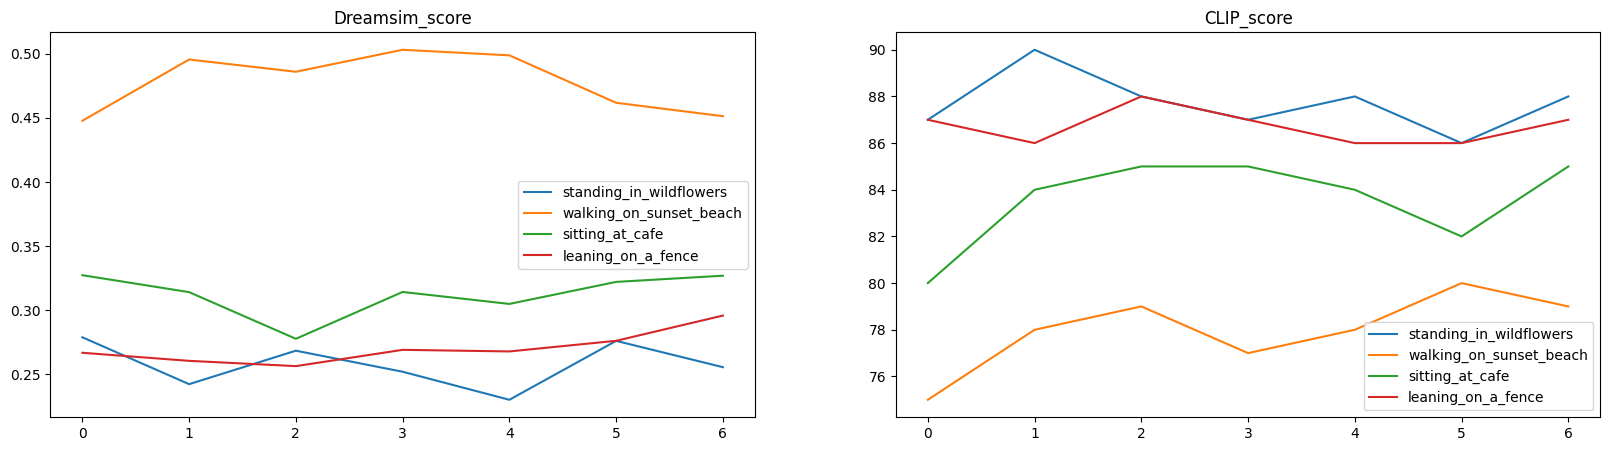

In [6]:
f, axarr = plt.subplots(1, 2, figsize=(20, 5))

for key in res_ds.keys():
    axarr[0].plot(res_ds[key].values(), label=key)
axarr[0].legend()
axarr[0].set_title("Dreamsim_score")

for key in res_ds.keys():
    axarr[1].plot(res[key].values(), label=key)
axarr[1].legend()
axarr[1].set_title("CLIP_score")

In [7]:
file_path = "/workspace/OneActor/" + dir_name + "_ds_old.pickle"
with open(file_path, "rb") as f:
    res_ds_old = pickle.load(f)

file_path = "/workspace/OneActor/" + dir_name + "_ds.pickle"
with open(file_path, "rb") as f:
    res_ds_old_2 = pickle.load(f)

standing_in_wildflowers: 0.25770579065595356 - 0.2488294243812561 - 0.2548372149467468
walking_on_sunset_beach: 0.477719851902553 - 0.4103096382958548 - 0.44735034874507357
sitting_at_cafe: 0.3125096985271999 - 0.29120499747140066 - 0.2887731875692095
leaning_on_a_fence: 0.27043584414890837 - 0.2853236368724278 - 0.24420074905667985


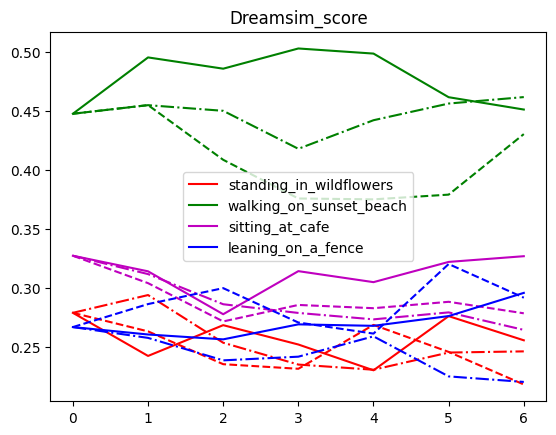

In [12]:
for key, color in zip(res_ds.keys(), ['r', 'g', 'm', 'b', 'o']):
    plt.plot(res_ds[key].values(), label=key, color=color)
    plt.plot(res_ds_old[key].values(), ls='--', color=color)
    plt.plot(res_ds_old_2[key].values(), ls='-.', color=color)
plt.legend()
plt.title("Dreamsim_score")

for key, color in zip(res_ds.keys(), ['r', 'g', 'm', 'b', 'o']):
    print(f"{key}: {np.mean(np.array(list(res_ds[key].values())))} - {np.mean(np.array(list(res_ds_old[key].values())))} - {np.mean(np.array(list(res_ds_old_2[key].values())))}")

In [33]:
for key, color in zip(res_ds.keys(), ['r', 'g', 'm', 'b', 'o']):
    print(f"{key}: {np.mean(np.array(list(res_ds[key].values())))} - {np.mean(np.array(list(res_ds_old[key].values())))}")

standing_in_wildflowers: 0.2548372149467468 - 0.2488294243812561
walking_on_sunset_beach: 0.44735034874507357 - 0.4103096382958548
sitting_at_cafe: 0.2887731875692095 - 0.29120499747140066
leaning_on_a_fence: 0.24420074905667985 - 0.2853236368724278
